# TODO
1. Maybe add the NSGA-II code to the other cells for ZDT-3 and ZDT-5? It's easier.

# Multi-objective optimization
This series of exercises will introduce basic concepts of multi-objective optimization (MOO). We are going to use mostly the **pymoo** library for the MOO algorithms and a few continuous optimization algorithms that we have already seen in the past (CMA-ES) as a baseline. The test functions presented are mostly continuous, but in principle MOO algorithms can also deal with discrete or mixed variable problems. Depending on the variables to be optimized in your problem, you will have to modify the operators that generate the candidate solutions accordingly (e.g. modify continuous variables with continuous modifications, and discrete variables with discrete modifications).

In [ ]:
# the code below just installs the libraries we are going to use
!pip install pymoo --quiet
!pip install cma --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210079 sha256=a25c91cb23c5707f5062aeff3bc4da807111e34632c60071adadc7f1648ab91d
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


## Test function: ZDT-1
A first test function for MOO is ZDT-1, a function with two objective that both have to be minimized. This version of ZDT-1 has 30 continuous variables to be optimized (or, in other terms, 30 dimensions).

This time, we are not going to visualize the search space of the function (with 30 dimensions it's difficult), but rather the **objective space** with the possible values of the two objectives. For ZDT-1, we actually know the **true Pareto front**, so we can easily evaluate different algorithms by checking how many points they manage to place on the Pareto front.

Here below is a visualization of the objective space for ZDT-1, with the true Pareto front.

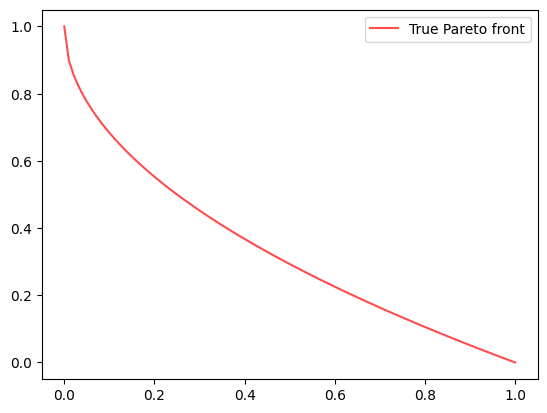

In [ ]:
import matplotlib.pyplot as plt
from pymoo.problems import get_problem

zdt1 = get_problem("zdt1")

fig = plt.figure()
ax = fig.add_subplot(111)
x = [point[0] for point in zdt1.pareto_front()]
y = [point[1] for point in zdt1.pareto_front()]
ax.plot(x, y, color="red", alpha=0.7, label="True Pareto front")
ax.legend(loc='best')

Now, we are going to test a classic single-objective algorithm, using weights to aggregate the two objectives of ZDT-1 into a single value, with an objective function that is a weighted sum.

In [ ]:
!pip install cma
import cma
def cmaes_optimization(function, starting_point, boundaries, random_seed=42, population_size=None, sigma=1e-2) :

    options = {'bounds' : list(boundaries), 'seed' : random_seed, 'popsize' : population_size}

    points_explored = []
    cmaes = cma.CMAEvolutionStrategy(starting_point, sigma, options)
    while not cmaes.stop() :
        solutions = cmaes.ask()
        cmaes.tell(solutions, [function(x) for x in solutions])
        cmaes.disp()
        points_explored.extend(solutions)

    return cmaes.result[0], points_explored

def zdt1_weighted(x, weight_1=0.5) :
  o1, o2 = zdt1.evaluate(x)
  return weight_1 * o1 + (1-weight_1) * o2

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 30 (seed=42, Thu Jul  6 21:31:58 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 4.861432201492457e-01 1.0e+00 9.38e-03  9e-03  9e-03 0:00.0
    2     28 4.838231673388309e-01 1.1e+00 9.01e-03  9e-03  9e-03 0:00.0
    3     42 4.812291638326808e-01 1.1e+00 9.00e-03  9e-03  9e-03 0:00.0
  100   1400 3.750259977030398e-01 1.8e+00 1.18e-03  1e-03  1e-03 0:00.5
  200   2800 3.750000094302250e-01 1.8e+00 2.19e-05  2e-05  2e-05 0:01.0
  300   4200 3.750000000011617e-01 1.8e+00 3.62e-07  2e-07  3e-07 0:01.9
  351   4914 3.750000000000198e-01 1.8e+00 4.58e-08  3e-08  4e-08 0:02.5


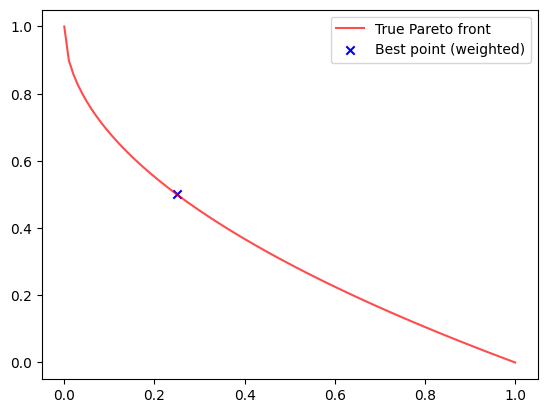

In [ ]:
zdt1_boundaries = [zdt1.xl, zdt1.xu]
best_point, points_explored = cmaes_optimization(zdt1_weighted, [0.0] * 30, zdt1_boundaries)
o1, o2 = zdt1.evaluate(best_point)

fig = plt.figure()
ax = fig.add_subplot(111)
x = [point[0] for point in zdt1.pareto_front()]
y = [point[1] for point in zdt1.pareto_front()]
ax.plot(x, y, color="red", alpha=0.7, label="True Pareto front")
ax.scatter(o1, o2, color='blue', marker='x', label="Best point (weighted)")
ax.legend(loc='best')

Try re-running the algorithm and changing the weights. What happens to the best point found?

Now, instead of using a single-objective algorithm, we are going to run an algorithm specialized in multi-objective optimization, NSGA-II. The results do not seem fantastic at first, can you modify its parameters (population size, number of generations) to improve its performance?

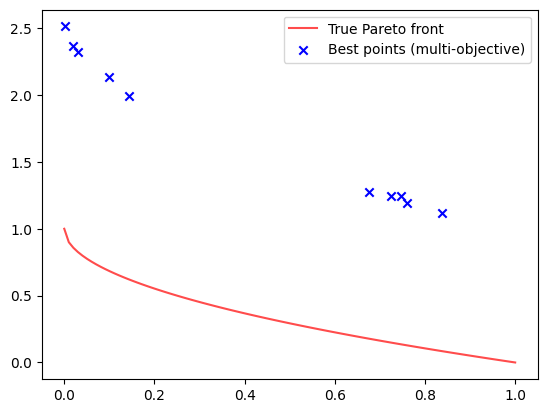

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

population_size = 10
number_of_generations = 30
random_seed = 42

algorithm = NSGA2(pop_size=population_size)
res = minimize(zdt1,
               algorithm,
               ('n_gen', number_of_generations),
               seed=random_seed,
               verbose=False)

# res.F is a list containing the non-dominated points found by the algorithm
fig = plt.figure()
ax = fig.add_subplot(111)
x = [point[0] for point in zdt1.pareto_front()]
y = [point[1] for point in zdt1.pareto_front()]
ax.plot(x, y, color="red", alpha=0.7, label="True Pareto front")
ax.scatter([x[0] for x in res.F], [x[1] for x in res.F], color='blue', marker='x', label="Best points (multi-objective)")
ax.legend(loc='best')

Now, try NSGA-II on another benchmark with a more complex shape of the Pareto front, ZDT-3, again trying to put as many points as possible on the true Pareto front. ZDT-3 has again 30 variables/dimensions.

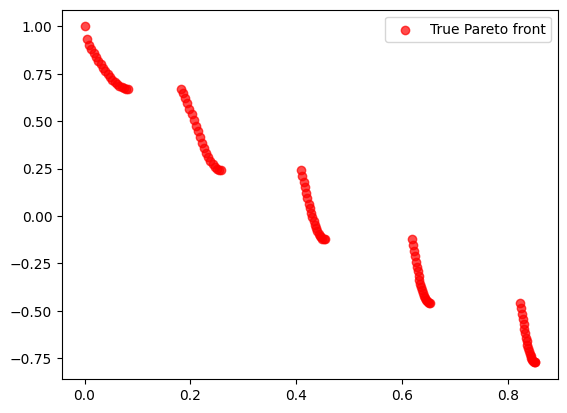

In [ ]:
zdt3 = get_problem("zdt3")

fig = plt.figure()
ax = fig.add_subplot(111)
x = [point[0] for point in zdt3.pareto_front()]
y = [point[1] for point in zdt3.pareto_front()]
ax.scatter(x, y, color="red", alpha=0.7, label="True Pareto front")
ax.legend(loc='best')

Now, let's work  on a final benchmark problem, where the variables are discrete. ZDT-5 has a total of 11 discrete variables, where the first has 30 bits, and the others have 5 bits each. They can be encoded as a single bit-string with 80 bits (80 values True/False, or 0/1 for example).

Example of a candidate solution: [False False  True  True False False  True False  True False  True  True
 False  True  True  True False  True  True  True  True  True  True  True
  True False False False  True  True False False False False False False
 False False  True False False False  True False False  True  True  True
  True  True  True  True  True  True  True False False  True False False
 False False False False False False False False False False False False
  True False False False  True False False False]


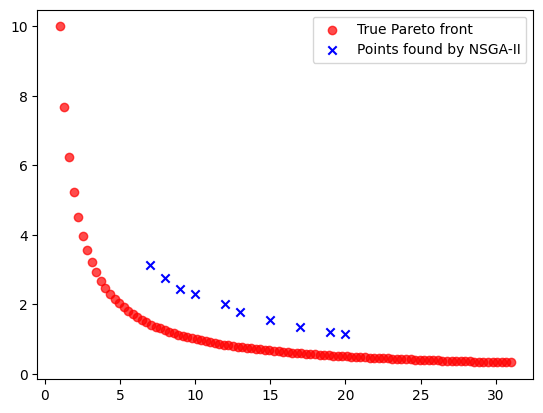

In [ ]:
zdt5 = get_problem("zdt5", normalize=False)

population_size = 10
number_of_generations = 30
random_seed = 42

# this time, we need to use specialized operators that work on discrete variables
# (and in this particular case, binary strings)
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling

algorithm = NSGA2(pop_size=population_size,
                  sampling=BinaryRandomSampling(),
                  crossover=TwoPointCrossover(),
                  mutation=BitflipMutation(),
                  eliminate_duplicates=True)

res = minimize(zdt5,
               algorithm,
               ('n_gen', number_of_generations),
               seed=random_seed,
               verbose=False)

fig = plt.figure()
ax = fig.add_subplot(111)
x = [point[0] for point in zdt5.pareto_front()]
y = [point[1] for point in zdt5.pareto_front()]
ax.scatter(x, y, color="red", alpha=0.7, label="True Pareto front")
ax.scatter([x[0] for x in res.F], [x[1] for x in res.F], color='blue', marker='x', label="Points found by NSGA-II")
ax.legend(loc='best')

print("Example of a candidate solution:", res.pop[0].x)